<a href="https://colab.research.google.com/github/muhammad-usama-aleem/Transfer-Learning-with-InceptionV3/blob/main/Transfer_Learning_with_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **download kaggle data in Google Colab**

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 74 bytes


In [2]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         66           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes         91           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        822           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        160           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1801           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      13775           False  
house-pr

In [3]:
!kaggle datasets download -d puneet6060/intel-image-classification

 99% 343M/346M [00:07<00:00, 72.4MB/s]
100% 346M/346M [00:07<00:00, 50.8MB/s]


In [4]:
!unzip /content/intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [5]:
# removing zip file
!rm -rf /content/intel-image-classification.zip

# **Importing Libraies**

In [6]:
import tensorflow as tf
import time

# use this command to allow growth of the memory and this prevent error.
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# if error is 'Physical error cannot be modified after being initailized', then restart kernel.

# **Load Data**

In [7]:
from tensorflow.keras import datasets

# importing cfiar dataset 
# (train_x, train_y), (test_x, test_y) = datasets.cifar10.load_data()

# **Preprocessing**

In [8]:
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

In [9]:
TRAIN_DIR = "/content/seg_train/seg_train"

In [10]:
# splitting into train and validation 
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.15, # seprating 15% of train dataset for validation 
    subset='training',
    seed=124, # give any non negative number to split the dataset into valid and split
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = 32
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.15,
    subset='validation',
    seed=124,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = 32
)

Found 14034 files belonging to 6 classes.
Using 11929 files for training.
Found 14034 files belonging to 6 classes.
Using 2105 files for validation.


In [11]:
class_names = train_data.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

# **Visualizing data set**

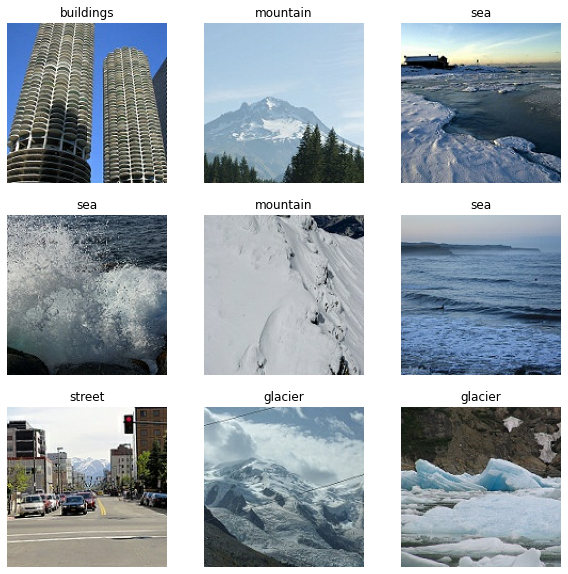

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# **Transfer Learning**

In [79]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [80]:
base_model = InceptionV3(weights='imagenet', include_top=False)

# include_top=False means last dense layer should be removed.

In [81]:
base_model.trainable = False
# making our base model untrainable to use the same weightss

In [82]:
inputs = tf.keras.Input(shape=(150, 150, 3))
# adding input layer for our model

In [83]:
#  adding data_augmentation layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
x = data_augmentation(inputs)

In [84]:
# now adding base model (inception) after our layers
x = base_model(x, training=False)

In [85]:
# adding flatten or GlobalAveragePooling2D layer, they do the same task
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
x = global_average_layer(x)

In [86]:
# adding dense layer
prediction_layer = tf.keras.layers.Dense(6)

In [87]:
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [88]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 21,815,078
Trainable params: 12,294
Non-trainable params: 21,802,784
__________________________________________

In [89]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [90]:
import datetime


start = time.time()
resp = model.fit(train_data, epochs=10)
stop = time.time()

Epoch 1/10
373/373 [==============================] - 37s 86ms/step - loss: 11.9318 - accuracy: 0.3713
Epoch 2/10
373/373 [==============================] - 32s 85ms/step - loss: 8.3486 - accuracy: 0.4170
Epoch 3/10
373/373 [==============================] - 32s 85ms/step - loss: 8.0543 - accuracy: 0.4276
Epoch 4/10
373/373 [==============================] - 32s 85ms/step - loss: 7.6171 - accuracy: 0.4368
Epoch 5/10
373/373 [==============================] - 32s 85ms/step - loss: 7.1192 - accuracy: 0.4469
Epoch 6/10
373/373 [==============================] - 32s 85ms/step - loss: 6.5484 - accuracy: 0.4506
Epoch 7/10
373/373 [==============================] - 32s 85ms/step - loss: 6.7526 - accuracy: 0.4513
Epoch 8/10
373/373 [==============================] - 31s 84ms/step - loss: 7.1631 - accuracy: 0.4439
Epoch 9/10
373/373 [==============================] - 32s 85ms/step - loss: 7.0289 - accuracy: 0.4539
Epoch 10/10
373/373 [==============================] - 32s 85ms/step - loss: 6.16

In [91]:
print(f"Training time: {stop - start}s")

Training time: 349.45815658569336s


In [ ]:
dir(resp)

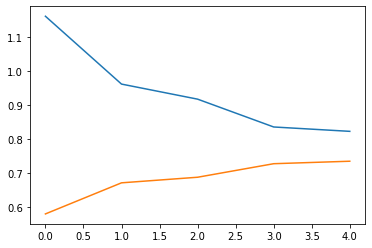

In [19]:
# plot accuracy and loss w.r.t epoch

import matplotlib.pyplot as plt


plt.plot(resp.epoch, resp.history['loss'])
plt.plot(resp.epoch, resp.history['accuracy'])

plt.show()

# **Evaluation**

In [22]:
model.evaluate(val_data)

66/66 [==============================] - 4s 33ms/step - loss: 0.7361 - accuracy: 0.7620


[0.7361153960227966, 0.761995255947113]

In [27]:
results = model.predict(val_data)

# **Save Model**

In [ ]:
model.save("inetlenv")

INFO:tensorflow:Assets written to: inetlenv/assets


# **Load Model**

In [24]:
# get label from valid_folder

orignal = []
for img, label in val_data:
  orignal.extend([int(val) for val in label])
print(orignal)

[0, 2, 0, 0, 0, 2, 4, 2, 2, 1, 5, 1, 3, 3, 3, 4, 3, 0, 0, 4, 0, 0, 2, 0, 5, 3, 5, 1, 2, 3, 4, 1, 4, 3, 2, 4, 3, 2, 2, 5, 2, 0, 2, 5, 5, 5, 3, 0, 0, 1, 5, 4, 5, 4, 2, 3, 1, 3, 5, 4, 1, 1, 3, 4, 0, 1, 4, 4, 5, 5, 4, 3, 3, 1, 5, 1, 0, 3, 3, 0, 3, 1, 4, 3, 1, 2, 3, 2, 2, 4, 4, 5, 0, 1, 3, 5, 3, 4, 0, 1, 0, 3, 4, 5, 4, 4, 3, 3, 4, 4, 0, 4, 2, 1, 2, 4, 2, 0, 4, 5, 5, 5, 2, 0, 2, 5, 5, 5, 3, 4, 3, 1, 4, 3, 1, 2, 4, 4, 5, 3, 0, 1, 5, 4, 1, 1, 4, 0, 3, 3, 3, 0, 4, 1, 3, 2, 1, 2, 1, 2, 1, 0, 2, 5, 1, 4, 5, 5, 0, 2, 0, 4, 3, 5, 1, 5, 1, 4, 5, 3, 3, 0, 4, 1, 0, 0, 4, 4, 1, 2, 0, 4, 3, 0, 0, 5, 2, 4, 4, 1, 3, 4, 4, 1, 5, 2, 2, 0, 5, 0, 4, 2, 5, 3, 3, 1, 5, 2, 1, 3, 2, 1, 3, 1, 4, 5, 0, 2, 4, 3, 4, 5, 1, 1, 4, 2, 5, 1, 4, 3, 5, 4, 5, 3, 5, 0, 3, 4, 4, 5, 4, 3, 2, 5, 4, 5, 3, 3, 0, 1, 2, 1, 4, 3, 0, 0, 3, 4, 4, 2, 0, 4, 4, 1, 2, 2, 1, 5, 1, 4, 3, 0, 3, 5, 3, 3, 3, 1, 4, 3, 5, 2, 4, 1, 4, 1, 3, 4, 4, 4, 5, 0, 5, 3, 3, 2, 3, 3, 1, 0, 1, 3, 0, 3, 4, 4, 3, 3, 3, 1, 5, 0, 0, 1, 4, 3, 3, 4, 0, 3, 2, 4, 2, 

In [28]:
import numpy as np
predictions = [np.argmax(cls) for cls in results]

In [32]:
from sklearn import metrics
resp = metrics.confusion_matrix(predictions, orignal)

In [33]:
import pandas as pd
df_cm = pd.DataFrame(resp, columns=class_names, index=class_names)
df_cm

,buildings,forest,glacier,mountain,sea,street
buildings,243,7,18,33,19,68
forest,9,334,3,1,5,18
glacier,5,1,240,51,14,2
mountain,2,1,26,213,6,1
sea,12,1,61,77,310,9
street,30,9,5,3,4,264


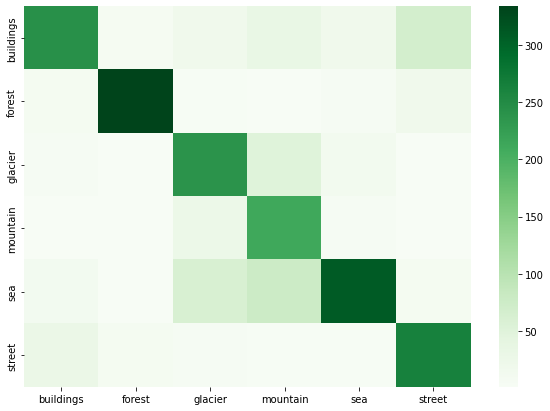

In [34]:
import seaborn as sns


plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, cmap='Greens')